# <center> Майнор "Интеллектуальный анализ данных" </center>

# <center> Курс "Введение в анализ данных" </center>

# <center> Лабораторная работа №2. Кластерный анализ. </center>

# Часть 1

В данном задании вам необходимо **самостоятельно** реализовать один из алгоритмов кластеризации.  
По аналогии с классами в scikit-learn, нужно реализовать класс, наследуемый от [Base Estimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html).  
Подробнее про реализацию своих моделей в scikit-learn: [here](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator).  
В классе помимо `__init__()` нужно реализовать два метода:
 - `fit()` - метод, выполняющий кластеризацию данных.
 - `predict()` - метод, определяющий для нового объекта, к какому из кластеров он относится. 
 
Для удобства можно создавать дополнительные методы класса, которые будут вызываться в `fit()` или `predict()`.  <br>
Функции для вычисления расстояний *между объектами* самим реализовывать не нужно, используйте реализации из `scipy`.

In [42]:
import sys
import warnings
import time
import random
import numpy as np
import pandas as pd
from scipy.spatial.distance import sqeuclidean
from sklearn.base import BaseEstimator, ClusterMixin

warnings.filterwarnings('ignore')

class IslamKMeans:
    def __init__(self, k=5, init='k-means++', n_init=10,
                 max_iter=300, tol=0.0001):
        """
        Initialization of K-Means algorithm
        :param k: number of clusters
        :param init: method for initialization k-means++ or random
        :param n_init: number of time the k-means algorithm will be run
                       with different centroid seeds
        :param max_iter: Maximum number of iterations of
                         the k-means algorithm for a single run
        :param tol: relative tolerance
        """
        self.k = k
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol

        self.X = ''
        self.inertia_ = float(sys.maxsize)
        self.cluster_centers_ = list()
        self.labels_ = ''
        self.clusters = [[] for _ in range(self.k)]
        self.n_samples = int
        self.n_features = int

    def k_means_plus(self):
        """
        Selects initial cluster centers for
        k-mean clustering in a smart way to speed up convergence
        :return: None
        """
        centroids_buf = list()
        random_sample_id = np.random.choice(self.n_samples, 1,
                                            replace=False)
        centroids_buf.append(self.X[random_sample_id])
        for id in range(self.k - 1):
            dist = []
            for i in range(self.n_samples):
                point = self.X[i, :]
                d = sys.maxsize
                for j in range(len(centroids_buf)):
                    temp_dist = sqeuclidean(point, centroids_buf[j])
                    d = min(d, temp_dist)
                dist.append(d)
            dist = np.array(dist)
            next_centroid = self.X[np.argmax(dist), :]
            centroids_buf.append(next_centroid)
        self.cluster_centers_ = list(centroids_buf)

    def random_find(self):
        """
        Choose n_clusters observations (rows) at random
        from data for the initial centroids
        :return: None
        """
        random_sample_idxs = np.random.choice(self.n_samples,
                                              self.k,
                                              replace=False)
        self.cluster_centers_ = [self.X[idx] for idx in random_sample_idxs]

    def fit(self, data):
        """
        Compute k-means clustering.
        :param data: algorithm training data
        :return: None
        """
        best_labels = self.labels_
        best_inertia = float(sys.maxsize)
        best_centroids = self.cluster_centers_
        self.X = data
        self.n_samples, self.n_features = data.shape
        for _ in range(self.n_init):
            if self.init == 'k-means++':
                self.k_means_plus()
            else:
                self.random_find()
            for _ in range(self.max_iter):
                self.clusters = self.add_to_cluster(self.cluster_centers_)
                self.cluster_centers_ = self.get_centres(self.clusters)
                if self.check_inertia() is True:
                    break
            if self.inertia_ < best_inertia:
                self.get_labels(clusters=self.clusters)
                best_labels = self.labels_.copy()
                best_centroids = self.cluster_centers_.copy()
                best_inertia = self.inertia_
        self.labels_ = best_labels.copy()
        self.cluster_centers_ = best_centroids.copy()
        self.inertia_ = best_inertia

    def predict(self, data):
        """
        Predict the closest cluster each sample in X belongs to.
        :param data: algorithm prediction data
        :return: list of the labels
        """
        self.X = data
        self.n_samples, self.n_features = data.shape
        other_clusters = self.create_clusters(self.cluster_centers_)
        return self.get_labels(other_clusters)

    def get_labels(self, clusters):
        """
        Turns the list of clusters into an easy-to-process list
        :param clusters: list of clusters
        :return: None
        """
        self.labels_ = np.empty(self.n_samples, dtype=int)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_index in cluster:
                self.labels_[sample_index] = cluster_idx

    def add_to_cluster(self, centroids):
        """
        Creates and adds points to specific clusters
        :param centroids: list of centroids
        :return: list of clusters
        """
        clusters = list()
        for _ in range(self.k):
            clusters.append([])
        for idx, sample in enumerate(self.X):
            centroid_idx = self.nearest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    @staticmethod
    def nearest_centroid(element, centroids):
        """
        Find the nearest centroid
        :param element: a definite point in our data
        :param centroids: list of centroids
        :return: numpy array with the nearest centroid
        """
        distances = list()
        for val in centroids:
            cur_dist = sqeuclidean(element, val)
            distances.append(cur_dist)
        index = np.argmin(distances)
        return index

    def get_centres(self, clusters):
        """
        Initialize centres for clusters
        :param clusters: list of clusters
        :return: array of centroids
        """
        centroids = np.zeros((self.k, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def check_inertia(self):
        """
        Finds inertia and determines when 
        the algorithm needs to end the action
        :return: bool
        """
        distance = 0
        for i in range(len(self.clusters)):
            for j in range(len(self.clusters[i])):
                point = self.X[self.clusters[i][j]]
                distance += sqeuclidean(point, self.cluster_centers_[i])
        if abs(distance - self.inertia_) < self.tol:
            return True
        else:
            self.inertia_ = distance
            return False

### Вариант №3

Алгоритм K-Means.  
  
Параметры: 
- **k:** число центров (кластеров);
- **init**: метод инициализации центров - random или kmeans++;
- **n_init**: число запусков алгоритма;
- **max_iter:** максимальное число итераций;  
- **tol:** минимальное значение изменения целевой функции.  
  
Атрибуты:  
- **inertia_:** Итоговое значение целевой функции;
- **cluster\_centers\_:** центры кластеров - ndarray of shape (n_clusters, n_features);
- **labels_:** метки кластеров для каждого объекта.  
  
Метод `predict()`:  Новый объект определяется в кластер, центр которого расположен ближе всех к этому объекту. 

### Тестирование 

Вашу реализацию необходимо сравнить с питоновской реализацией алгоритма из `sklearn` или `scipy`. Результаты кластеризации должны совпадать.  
Также необходимо сравнить скорость работы вашей реализации и питоновской (это нормально, если ваша реализация будет медленнее).  
Сравнение необходимо выполнить на наборе данных iris.

In [43]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
iris = load_iris()
X_train = iris.data # использовать для кластеризации
y = iris.target # истинные метки цветков
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [45]:
X = pd.DataFrame(X, columns=iris.feature_names)
X['class'] = [iris.target_names[i] for i in y]
X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


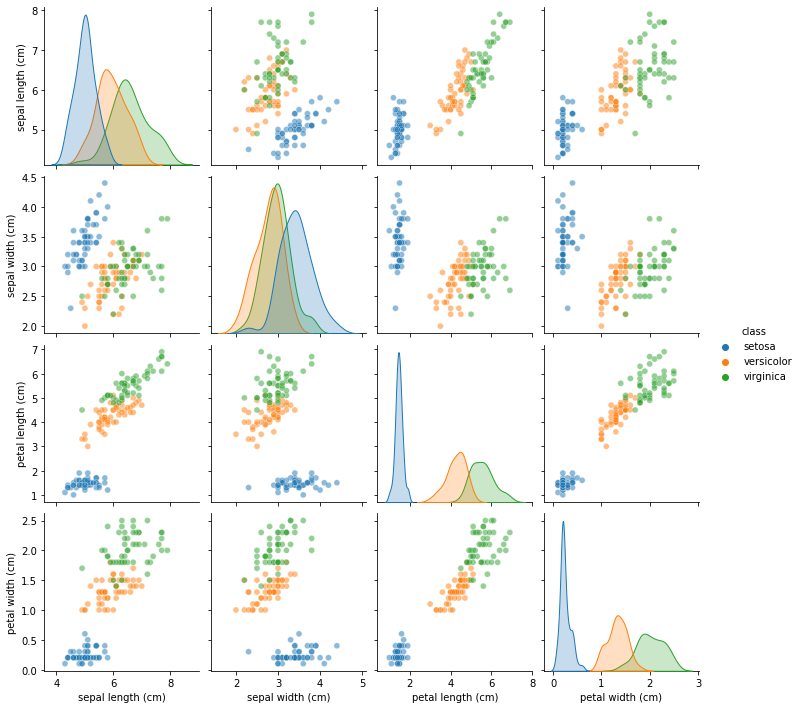

In [46]:
sns.pairplot(X, hue='class', plot_kws={'alpha':0.5}, vars=iris.feature_names)
plt.show()

#### В первую очередь нам для тестирования алгоритмов необходимо провести стандартизацию данных. Для этого используем StandartScaler

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
sc = StandardScaler()
scal_data = sc.fit_transform(X_train)

In [49]:
scal_X = pd.DataFrame()
for point, i in zip(iris.feature_names, range(len(iris.feature_names))):
    scal_X[point] = scal_data[:, i]

#### Тестирование IslamK-Means

In [50]:
islam_k_means = IslamKMeans(k=3)
scal_data_copy = scal_X.copy()

In [54]:
st_time = time.time()
islam_k_means.fit(scal_data_copy.to_numpy())
fin_time = time.time()

#### Визуализация полученных результатов

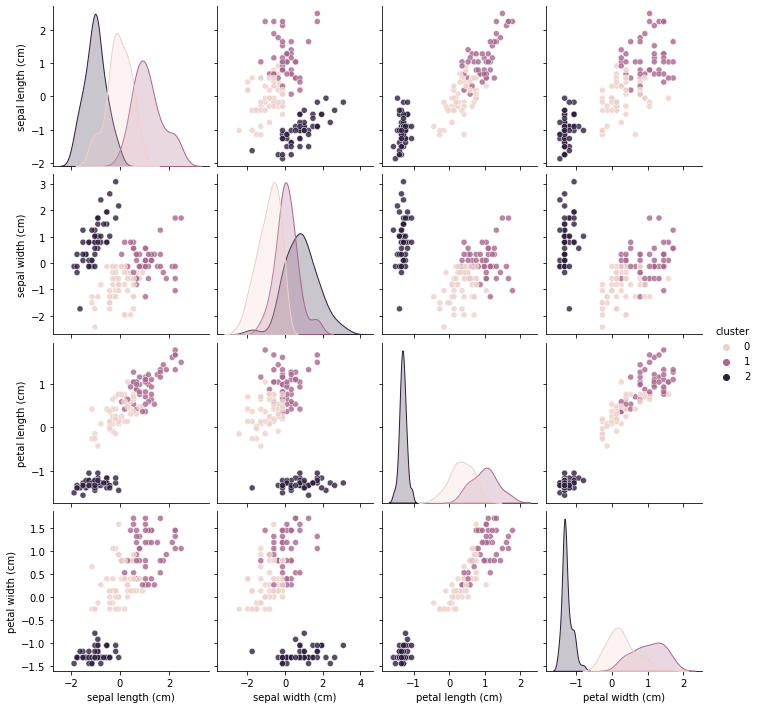

In [59]:
scal_data_copy['cluster'] = islam_k_means.labels_
sns.pairplot(scal_data_copy, hue='cluster', 
             plot_kws={'alpha': 0.8}, vars=iris.feature_names,
             )
plt.show()

### Бонусное  
  
Дополнительно вы можете поработать над эффективностью алгоритма по скорости и памяти, добавить поддержку многопоточности, или расширить базовый функционал.

### Распределение по вариантам

In [6]:
pd.set_option('display.max_rows', 50)

In [7]:
Vars = pd.read_csv('Vars.txt', sep='\t')

#### Вариант №1

In [8]:
Vars[Vars.iloc[:,2] == 1]

,ФИО,Группа,Вариант №
0,Бакурский Андрей Сергеевич,1 ИАД,1
2,Бекина Светлана Сергеевна,1 ИАД,1
3,Бекусов Михаил Александрович,1 ИАД,1
9,Конина Татьяна Дмитриевна,1 ИАД,1
11,Лукичева Полина Александровна,1 ИАД,1
12,Моничева Арина Александровна,1 ИАД,1
22,Трухин Егор Сергеевич,1 ИАД,1
23,Шарунов Евгений Александрович,1 ИАД,1
24,Шатилов Виктор Алексеевич,1 ИАД,1
27,Астахова Елизавета Евгеньевна,2 ИАД,1


#### Вариант №2

In [9]:
Vars[Vars.iloc[:,2] == 2]

,ФИО,Группа,Вариант №
1,Балаян Роман Каренович,1 ИАД,2
5,Даняев Артем Андреевич,1 ИАД,2
7,Ешманов Павел Андреевич,1 ИАД,2
10,Костин Андрей Олегович,1 ИАД,2
15,Ожиганова Полина Максимовна,1 ИАД,2
17,Сапожников Андрей Михайлович,1 ИАД,2
18,Семаев Никита Юрьевич,1 ИАД,2
21,Суворов Артём Андреевич,1 ИАД,2
25,Южаков Максим Вячеславович,1 ИАД,2
28,Бабий Александр Сергеевич,2 ИАД,2


#### Вариант №3

In [10]:
Vars[Vars.iloc[:,2] == 3]

,ФИО,Группа,Вариант №
4,Боряев Сергей Сергеевич,1 ИАД,3
6,Дыряев Даниил Александрович,1 ИАД,3
8,Игумнова Наталья Дмитриевна,1 ИАД,3
13,Мурзинов Михаил Денисович,1 ИАД,3
14,Николаева Олеся Игоревна,1 ИАД,3
16,Османов Ислам Рамилевич,1 ИАД,3
19,Смирнов Григорий Андреевич,1 ИАД,3
20,Стифеев Никита Владимирович,1 ИАД,3
26,Арбузова Екатерина Михайловна,2 ИАД,3
31,Варгин Дмитрий Александрович,2 ИАД,3


# Часть 2

В данном задании вам предлагается проанализировать набор данных по различным городам США. Каждый город характеризуется следующими признаками:

In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
data_desc = pd.read_csv('Data_Description.txt', sep=':')
data_desc

,Attribute,Description
0,Place,"City, state (postal code)"
1,Climate & Terrain,"Very hot and very cold months, seasonal temperature variation, heating- and cooling-degree days, freezing days, zero-degree days, ninety-degree days."
2,Housing,"Utility bills, property taxes, mortgage payments."
3,Health Care & Environment,"Per capita physicians, teaching hospitals, medical schools, cardiac rehabilitation centers, comprehensive cancer treatment centers, hospices, insurance/hospitalization costs index, flouridation of drinking water, air pollution."
4,Crime,"Violent crime rate, property crime rate."
5,Transportation,"Daily commute, public transportation, Interstate highways, air service, passenger rail service."
6,Education,"Pupil/teacher ratio in the public K-12 system, effort index in K-12, accademic options in higher education."
7,The Arts,"Museums, fine arts and public radio stations, public television stations, universities offering a degree or degrees in the arts, symphony orchestras, theatres, opera companies, dance companies, public libraries."
8,Recreation,"Good restaurants, public golf courses, certified lanes for tenpin bowling, movie theatres, zoos, aquariums, family theme parks, sanctioned automobile race tracks, pari-mutuel betting attractions, major- and minor- league professional sports teams, NCAA Division I football and basketball teams, miles of ocean or Great Lakes coastline, inland water, national forests, national parks, or national wildlife refuges, Consolidated Metropolitan Statistical Area access."
9,Economics,"Average household income adjusted for taxes and living costs, income growth, job growth."


### Notes:   
* Для всех признаков, кроме трех, чем выше значение - тем лучше. Для признаков `Housing` и `Crime` - наоборот.
* Признак `Population`- статистический признак, не имеющий интерпретации как “лучше-хуже”.
* Признак `Place` - уникальный идентификатор объекта (города), он не должен использоваться при кластеризации.
* Также в данных присутствуют географические координаты городов - `Longitude` и `Latitude`. Их также не следует использовать при кластеризации данных.

In [13]:
data = pd.read_csv('Data.txt', sep=' ')
data

,Place,Climate,HousingCost,HlthCare,Crime,Transp,Educ,Arts,Recreat,Econ,Long,Lat,Pop
0,"Abilene,TX",521,6200,237,923,4031,2757,996,1405,7633,-99.6890,32.5590,110932
1,"Akron,OH",575,8138,1656,886,4883,2438,5564,2632,4350,-81.5180,41.0850,660328
2,"Albany,GA",468,7339,618,970,2531,2560,237,859,5250,-84.1580,31.5750,112402
3,"Albany-Schenectady-Troy,NY",476,7908,1431,610,6883,3399,4655,1617,5864,-73.7983,42.7327,835880
4,"Albuquerque,NM",659,8393,1853,1483,6558,3026,4496,2612,5727,-106.6500,35.0830,419700
...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,"Worcester,MA",562,8715,1805,680,3643,3299,1784,910,5040,-71.7950,42.2720,402918
325,"Yakima,WA",535,6440,317,1106,3731,2491,996,2140,4986,-120.5130,46.5950,172508
326,"York,PA",540,8371,713,440,2267,2903,1022,842,4946,-76.7280,39.9600,381255
327,"Youngstown-Warren,OH",570,7021,1097,938,3374,2920,2797,1327,3894,-80.7290,41.1700,531350


<br>  
  
## Задания: 

1. Выполните необходимую предобработку данных. Перед кластеризацией исключите из данных признаки `Place`, `Long` и `Lat`.  
  
  
2. Выполните кластеризацию иерархическим методом.  
Рассмотрите различные расстояния между объектами. Определите, какие следует использовать при кластеризации.  
Выполните кластеризацию с различными расстояниями между кластерами. Сравните результаты, сделайте выводы. 
  
  
3. Выполните кластеризацию методом Dbscan. Используйте расстояния между объектами, определенные в предыдущем пункте.  
Реализуйте эвристику (см. лекции) для выбора параметров алгоритма. Подберите подходящие параметры алгоритма.  
  
  
4. Выполните кластеризацию методом kmeans. Определите наилучшее (на ваш взгляд) число кластеров.  
  
  
5. (Бонусное) Выполните кластеризацию другими методами. Например, [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/) или алгоритмы, [реализованные](https://scikit-learn.org/stable/modules/clustering.html) в scikit-learn.  
  
  
6. В результате выполнения предыдущих пунктов вы должны получить 4 или больше разбиений объектов (по одному на каждый метод). Сравните их между собой, сделайте выводы о сходствах и различиях.  
Оцените результаты каждой кластеризации, используя метрики, рассмотренные на занятиях (Silhouette и прочие).  
  
  
7. Выберите одно разбиение, наиболее подходящее на ваш взгляд. Предложите интерпретацию полученным кластерам или покажите, что этого сделать нельзя.  
  
  
8. Оцените, как полученные кластеры распределены географически.  
Оцените, как полученные кластеры распределены по штатам. Можно ли выделить какую-то зависимость (территориальную или для штатов)?  
(Бонусное) [Провизуализируйте](https://python-visualization.github.io/folium/quickstart.html) распределение на карте США.